In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python# For example, here's several helpful packages to loadimport numpy as np # linear algebraimport pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)# Input data files are available in the read-only "../input/" directory# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directoryimport osfor dirname, _, filenames in os.walk('/kaggle/input'):    for filename in filenames:        print(os.path.join(dirname, filename))# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install openpyxl # Install the openpyxl library using pip

In [3]:
import pandas as pd # Import the pandas library and assign it to the alias 'pd'
df = pd.read_excel('/content/glassdoor_reviews_COPY_FULL.xlsx')
# Now you can work with the dataframe 'df'
# Example: print the first 5 rows
df.head()

,Review ID,Company Name,Overall Rating,Header,Job Title,Employment Status,Employment Tenure,Location,Recommend,CEO Approval,Business Outlook,Pros,Cons,Review Date
0,1,Deloitte,3,Good learning,Senior manager,Current employee,more than 10 years,Mumbai,Yes,Yes,Yes,Lot of learning and to work on latest technolo...,Work life fit and bureaucracy,"Oct 28, 2024"
1,2,Deloitte,3,Work environment,Senior tax manager,Current employee,more than 10 years,Portugal,No,No Data,No,Acess to information and a lot of learning cou...,Environment very competitive between colleague...,"Oct 28, 2024"
2,3,Deloitte,4,Good work culture,Analyst,Current employee,less than 1 year,Hyderābād,Yes,Yes,Yes,Flexi and nice people communication,Less salary and also growth is slow,"Oct 28, 2024"
3,4,Deloitte,4,Good place,Senior developer,Current employee,NaN,Bengaluru,No Data,No Data,No Data,Good working culture in the office,Less salary and less increments,"Oct 28, 2024"
4,5,Deloitte,3,Life at deloitte,Tax consultant,Former employee,NaN,Pune,No Data,No Data,No Data,"Great working environment, Good mentoring",Too many working hours and no extra payment,"Oct 28, 2024"


In [4]:
# prompt: Remove stop words from Pros column and Cons column and change it all to lower case

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    if isinstance(text, str):  # Check if the input is a string
        words = text.lower().split()
        filtered_words = [word for word in words if word not in stop_words]
        return " ".join(filtered_words)
    else:
        return text  # Return the original value if it's not a string

df['Pros'] = df['Pros'].apply(remove_stopwords)
df['Cons'] = df['Cons'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# prompt: Remove special characters from Pros and Cons column. Also remove the word "page" from it

import re

def remove_special_characters(text):
    if isinstance(text, str):
        # Remove special characters and the word "page"
        text = re.sub(r'[^\w\s]', '', text)
        text = text.replace("page", "")
        return text
    else:
        return text

df['Pros'] = df['Pros'].apply(remove_special_characters)
df['Cons'] = df['Cons'].apply(remove_special_characters)
df.head()

,Review ID,Company Name,Overall Rating,Header,Job Title,Employment Status,Employment Tenure,Location,Recommend,CEO Approval,Business Outlook,Pros,Cons,Review Date
0,1,Deloitte,3,Good learning,Senior manager,Current employee,more than 10 years,Mumbai,Yes,Yes,Yes,lot learning work latest technologies,work life fit bureaucracy,"Oct 28, 2024"
1,2,Deloitte,3,Work environment,Senior tax manager,Current employee,more than 10 years,Portugal,No,No Data,No,acess information lot learning courses,environment competitive colleagues,"Oct 28, 2024"
2,3,Deloitte,4,Good work culture,Analyst,Current employee,less than 1 year,Hyderābād,Yes,Yes,Yes,flexi nice people communication,less salary also growth slow,"Oct 28, 2024"
3,4,Deloitte,4,Good place,Senior developer,Current employee,NaN,Bengaluru,No Data,No Data,No Data,good working culture office,less salary less increments,"Oct 28, 2024"
4,5,Deloitte,3,Life at deloitte,Tax consultant,Former employee,NaN,Pune,No Data,No Data,No Data,great working environment good mentoring,many working hours extra payment,"Oct 28, 2024"


In [24]:
###create manager vs non-manager column
!pip install python-Levenshtein

import pandas as pd
import nltk
from nltk.corpus import wordnet
import re
import Levenshtein as lev

# Ensure necessary NLTK resources are downloaded
nltk.download('wordnet')
nltk.download('omw-1.4')


# Define initial managerial keywords
managerial_keywords = [
    "manager", "supervisor", "director", "chief", "leader", "head", "coordinator", "foreman", "boss",
    "lead", "president", "vice president", "general manager", "team lead"
]

# Function to generate synonyms for a word using WordNet
def generate_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())  # Add lemma to set (no duplicates)
    return synonyms

# Generate synonyms for all managerial keywords
all_synonyms = set()
for keyword in managerial_keywords:
    all_synonyms.update(generate_synonyms(keyword))

# Combine initial keywords with generated synonyms
combined_keywords = set(managerial_keywords).union(all_synonyms)

# Function to classify roles as managerial or non-managerial
def classify_role(job_title):
    job_title = job_title.lower()  # Convert job title to lowercase
    # Check if any managerial synonym or keyword is in the job title
    for keyword in combined_keywords:
        if keyword in job_title:
            return 1  # Managerial role
    # Additional misspelling check using Levenshtein distance
    misspelled_count = sum(lev.distance(keyword, job_title) <= 2 for keyword in combined_keywords)
    if misspelled_count > 0:
        return 1  # If a close match is found, classify as managerial
    return 0  # Non-managerial role

# Apply the function to the 'Job Title' column and create a new 'Managerial' column
df['Managerial'] = df['Job Title'].apply(classify_role)

# Display the updated DataFrame
print(df)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


       Review ID Company Name  Overall Rating  \
0              1     Deloitte               3   
1              2     Deloitte               3   
2              3     Deloitte               4   
3              4     Deloitte               4   
4              5     Deloitte               3   
...          ...          ...             ...   
99424      99425           EY               1   
99425      99426           EY               3   
99426      99427           EY               5   
99427      99428           EY               4   
99428      99429           EY               5   

                                                  Header  \
0                                          Good learning   
1                                       Work environment   
2                                      Good work culture   
3                                             Good place   
4                                       Life at deloitte   
...                                                

In [25]:
df.head()

,Review ID,Company Name,Overall Rating,Header,Job Title,Employment Status,Employment Tenure,Location,Recommend,CEO Approval,Business Outlook,Pros,Cons,Review Date,employment status_encoded,Review,Managerial
0,1,Deloitte,3,Good learning,Senior manager,Current employee,more than 10 years,Mumbai,Yes,Yes,Yes,lot learning work latest technologies,work life fit bureaucracy,"Oct 28, 2024",1,lot learning work latest technologies work lif...,1
1,2,Deloitte,3,Work environment,Senior tax manager,Current employee,more than 10 years,Portugal,No,No Data,No,acess information lot learning courses,environment competitive colleagues,"Oct 28, 2024",1,acess information lot learning courses environ...,1
2,3,Deloitte,4,Good work culture,Analyst,Current employee,less than 1 year,Hyderābād,Yes,Yes,Yes,flexi nice people communication,less salary also growth slow,"Oct 28, 2024",1,flexi nice people communication less salary al...,0
3,4,Deloitte,4,Good place,Senior developer,Current employee,NaN,Bengaluru,No Data,No Data,No Data,good working culture office,less salary less increments,"Oct 28, 2024",1,good working culture office less salary less i...,0
4,5,Deloitte,3,Life at deloitte,Tax consultant,Former employee,NaN,Pune,No Data,No Data,No Data,great working environment good mentoring,many working hours extra payment,"Oct 28, 2024",0,great working environment good mentoring many ...,0


In [21]:
# prompt: print column names

df.columns

Index(['Review ID', 'Company Name', 'Overall Rating', 'Header', 'Job Title',
       'Employment Status', 'Employment Tenure', 'Location', 'Recommend',
       'CEO Approval', 'Business Outlook', 'Pros', 'Cons', 'Review Date',
       'employment status_encoded', 'Review', 'Managerial'],
      dtype='object')

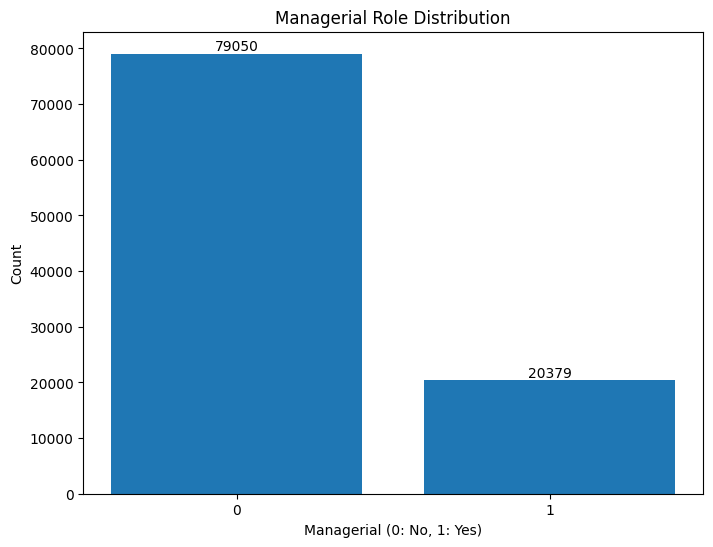

In [26]:
# prompt: count bar chart for Managerial with count showing in chart

import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' is your DataFrame and it has a 'Managerial' column
# created as described in the previous code.

managerial_counts = df['Managerial'].value_counts()

# Create the bar chart
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
bars = plt.bar(managerial_counts.index, managerial_counts.values)

# Add count labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom')

plt.xlabel("Managerial (0: No, 1: Yes)")
plt.ylabel("Count")
plt.title("Managerial Role Distribution")
plt.xticks(managerial_counts.index)  # Ensure x-axis ticks match the categories
plt.show()

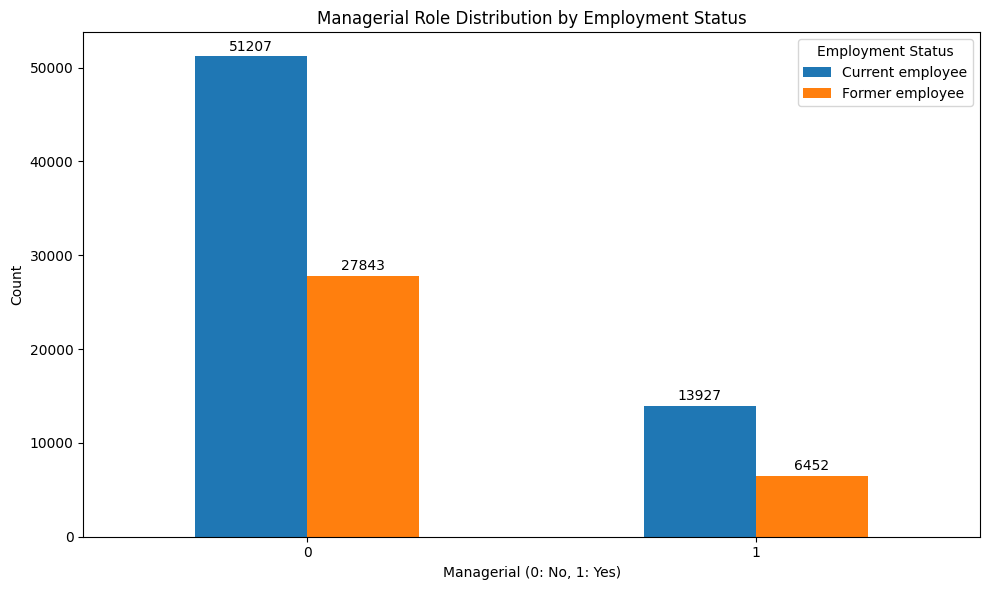

In [27]:
# prompt: count bar chart for Managerial with Employment Status with count showing in chart

import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it has columns 'Managerial' and 'Employment Status'.

# Group by 'Managerial' and 'Employment Status' and count occurrences
managerial_employment_counts = df.groupby(['Managerial', 'Employment Status']).size().unstack(fill_value=0)

# Create the bar chart
managerial_employment_counts.plot(kind='bar', figsize=(10, 6))
plt.xlabel("Managerial (0: No, 1: Yes)")
plt.ylabel("Count")
plt.title("Managerial Role Distribution by Employment Status")
plt.xticks(rotation=0) # Rotates X-axis labels for better readability

# Add count labels on top of each bar
for p in plt.gca().patches:
    plt.gca().annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 7), textcoords='offset points')


plt.legend(title='Employment Status')
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

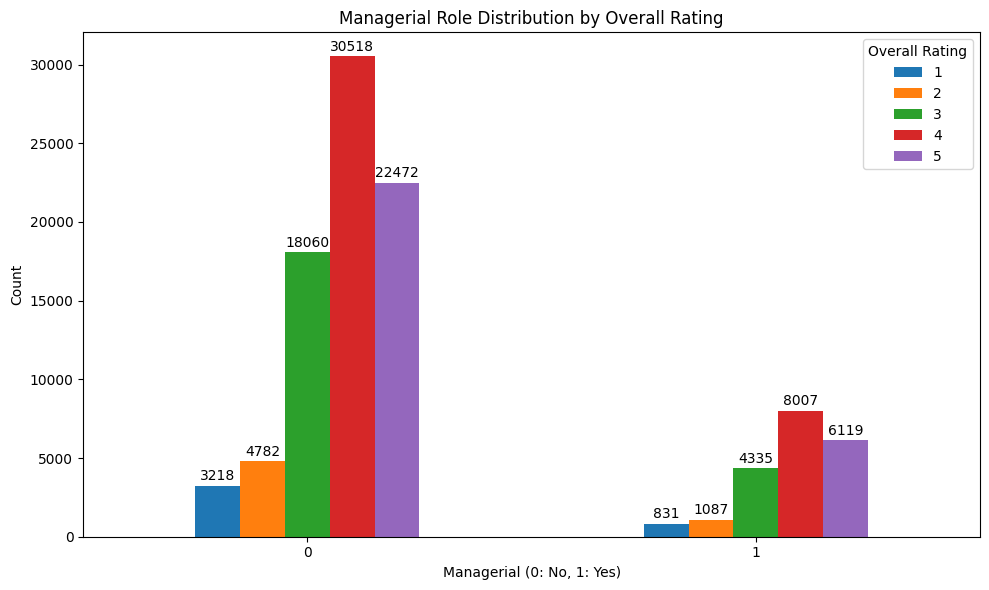

In [32]:
# prompt: count bar chart for Managerial vs non-managerial  including Overall Rating count with count showing in chart.

import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it has columns 'Managerial' and 'Overall Rating'.

# Group by 'Managerial' and 'Overall Rating' and count occurrences
managerial_rating_counts = df.groupby(['Managerial', 'Overall Rating']).size().unstack(fill_value=0)

# Create the bar chart
ax = managerial_rating_counts.plot(kind='bar', figsize=(10, 6))
plt.xlabel("Managerial (0: No, 1: Yes)")
plt.ylabel("Count")
plt.title("Managerial Role Distribution by Overall Rating")
plt.xticks(rotation=0)

# Add count labels on top of each bar
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 7), textcoords='offset points')

plt.legend(title='Overall Rating')
plt.tight_layout()
plt.show()

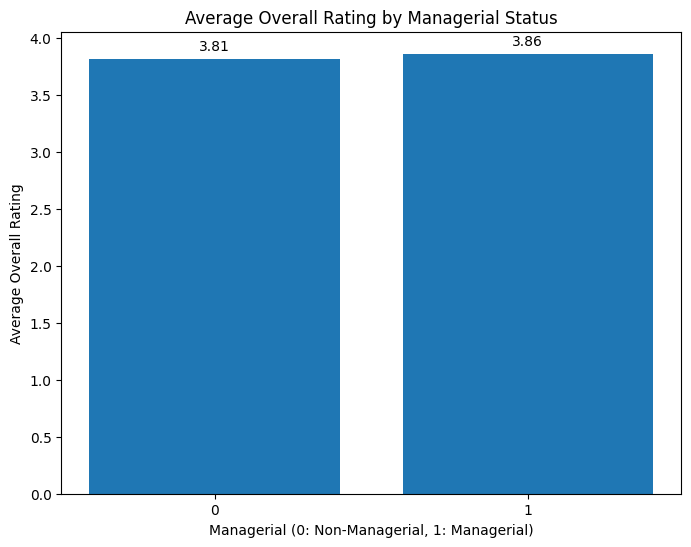

In [34]:
# prompt: build a chart, with Managerial and Employment Status in x axis showing Overall Rating across these classes. X axis should show 0 as non-managerial and 1 as managerial

import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it has columns 'Managerial' and 'Overall Rating'.

# Group data by 'Managerial' and calculate the mean 'Overall Rating' for each group
managerial_rating_mean = df.groupby('Managerial')['Overall Rating'].mean()

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(managerial_rating_mean.index, managerial_rating_mean.values)

plt.xlabel("Managerial (0: Non-Managerial, 1: Managerial)")
plt.ylabel("Average Overall Rating")
plt.title("Average Overall Rating by Managerial Status")
plt.xticks(managerial_rating_mean.index)

# Add value labels above each bar
for i, v in enumerate(managerial_rating_mean.values):
    plt.text(i, v + 0.05, f"{v:.2f}", ha='center', va='bottom')

plt.show()

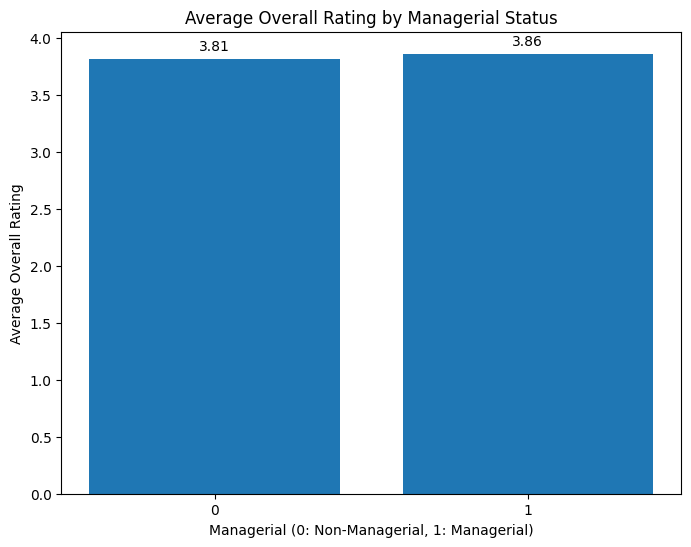

In [36]:
# prompt: Show spread of overall rating for Managerial vs non-managerial roles

import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it has columns 'Managerial' and 'Overall Rating'.

# Group data by 'Managerial' and calculate the mean 'Overall Rating' for each group
managerial_rating_mean = df.groupby('Managerial')['Overall Rating'].mean()

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(managerial_rating_mean.index, managerial_rating_mean.values)

plt.xlabel("Managerial (0: Non-Managerial, 1: Managerial)")
plt.ylabel("Average Overall Rating")
plt.title("Average Overall Rating by Managerial Status")
plt.xticks(managerial_rating_mean.index)

# Add value labels above each bar
for i, v in enumerate(managerial_rating_mean.values):
    plt.text(i, v + 0.05, f"{v:.2f}", ha='center', va='bottom')

plt.show()

In [6]:
# prompt: lemmatize words in Pros and Cons columns so that they convert to base
!pip install nltk
import nltk

# Download the required data package
nltk.download('punkt_tab')

# ... (your existing code) ...

import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

def lemmatize_text(text):
    """Lemmatizes words in a given text."""
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)  # Tokenize the text into words
    lemmas = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(lemmas)  # Join the lemmas back into a string

# Create the 'wordsdf' DataFrame by copying 'df'
wordsdf = df.copy()  # Now 'wordsdf' is defined

wordsdf['Pros'] = df['Pros'].astype(str).apply(lemmatize_text)
wordsdf['Cons'] = df['Cons'].astype(str).apply(lemmatize_text)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
# prompt: create a new column "employment status_encoded" which has Employment status values 0 for Former employee and 1 for Current employee

# Create the new column 'employment status_encoded'
df['employment status_encoded'] = df['Employment Status'].map({'Former employee': 0, 'Current employee': 1})

In [8]:
# prompt: create a new column "Review" that joins the Pros and Cons columns

# Assuming 'df' is your DataFrame as defined in the previous code
df['Review'] = df['Pros'].astype(str) + ' ' + df['Cons'].astype(str)
df.head()

,Review ID,Company Name,Overall Rating,Header,Job Title,Employment Status,Employment Tenure,Location,Recommend,CEO Approval,Business Outlook,Pros,Cons,Review Date,employment status_encoded,Review
0,1,Deloitte,3,Good learning,Senior manager,Current employee,more than 10 years,Mumbai,Yes,Yes,Yes,lot learning work latest technologies,work life fit bureaucracy,"Oct 28, 2024",1,lot learning work latest technologies work lif...
1,2,Deloitte,3,Work environment,Senior tax manager,Current employee,more than 10 years,Portugal,No,No Data,No,acess information lot learning courses,environment competitive colleagues,"Oct 28, 2024",1,acess information lot learning courses environ...
2,3,Deloitte,4,Good work culture,Analyst,Current employee,less than 1 year,Hyderābād,Yes,Yes,Yes,flexi nice people communication,less salary also growth slow,"Oct 28, 2024",1,flexi nice people communication less salary al...
3,4,Deloitte,4,Good place,Senior developer,Current employee,NaN,Bengaluru,No Data,No Data,No Data,good working culture office,less salary less increments,"Oct 28, 2024",1,good working culture office less salary less i...
4,5,Deloitte,3,Life at deloitte,Tax consultant,Former employee,NaN,Pune,No Data,No Data,No Data,great working environment good mentoring,many working hours extra payment,"Oct 28, 2024",0,great working environment good mentoring many ...


In [18]:
!pip install imblearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.base import FunctionSampler
import numpy as np

# Function to apply SMOTE during pipeline execution
def smote_resampler(X, y):
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)
    return X_res, y_res

# Sample data
texts = df['Review']
labels = df['employment status_encoded']

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    texts,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels  # Ensures class distribution is preserved
)

# Define pipeline
pipeline = ImbPipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english', max_features=1000, max_df=0.95, min_df=0.05, ngram_range=(1, 2))),
    ('smote', FunctionSampler(func=smote_resampler, validate=False)),
    ('lda', LatentDirichletAllocation(n_components=2, random_state=42, learning_method='online', max_iter=10, learning_decay=0.7)),
    ('classifier', RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42))
])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)
score = accuracy_score(y_test, y_pred)
print(f"RandomForestClassifier Accuracy: {score}")
print(classification_report(y_test, y_pred))



RandomForestClassifier Accuracy: 0.5499346273760435
              precision    recall  f1-score   support

           0       0.36      0.40      0.38      6859
           1       0.67      0.63      0.65     13027

    accuracy                           0.55     19886
   macro avg       0.51      0.52      0.51     19886
weighted avg       0.56      0.55      0.56     19886



In [12]:
df.head()

,Review ID,Company Name,Overall Rating,Header,Job Title,Employment Status,Employment Tenure,Location,Recommend,CEO Approval,Business Outlook,Pros,Cons,Review Date,employment status_encoded,Review
0,1,Deloitte,3,Good learning,Senior manager,Current employee,more than 10 years,Mumbai,Yes,Yes,Yes,lot learning work latest technologies,work life fit bureaucracy,"Oct 28, 2024",1,lot learning work latest technologies work lif...
1,2,Deloitte,3,Work environment,Senior tax manager,Current employee,more than 10 years,Portugal,No,No Data,No,acess information lot learning courses,environment competitive colleagues,"Oct 28, 2024",1,acess information lot learning courses environ...
2,3,Deloitte,4,Good work culture,Analyst,Current employee,less than 1 year,Hyderābād,Yes,Yes,Yes,flexi nice people communication,less salary also growth slow,"Oct 28, 2024",1,flexi nice people communication less salary al...
3,4,Deloitte,4,Good place,Senior developer,Current employee,NaN,Bengaluru,No Data,No Data,No Data,good working culture office,less salary less increments,"Oct 28, 2024",1,good working culture office less salary less i...
4,5,Deloitte,3,Life at deloitte,Tax consultant,Former employee,NaN,Pune,No Data,No Data,No Data,great working environment good mentoring,many working hours extra payment,"Oct 28, 2024",0,great working environment good mentoring many ...


<ipython-input-14-b7461a6b07cf>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Company Name', data=df, palette=company_colors, order=company_review_counts.index)


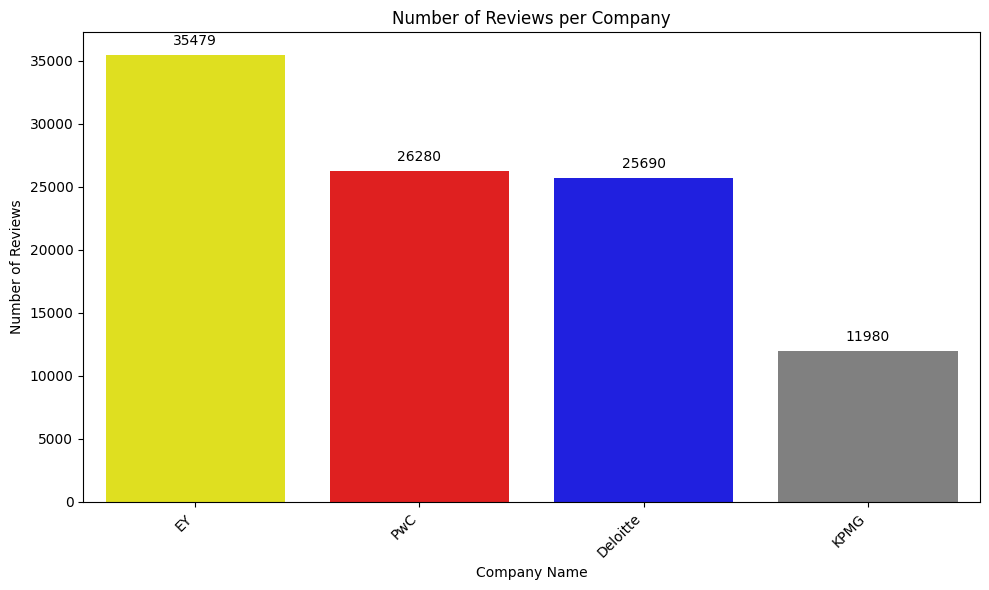

In [14]:
# prompt: create a count bar chart for number of reviews for each Company Name, keeping EY yellow, PwC red, Deloitte as blue and KPMG as grey

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame as defined in the previous code
company_review_counts = df['Company Name'].value_counts()

# Create a color dictionary for the companies
company_colors = {
    'EY': 'yellow',
    'PwC': 'red',
    'Deloitte': 'blue',
    'KPMG': 'grey'
}

# Create the bar plot using seaborn
plt.figure(figsize=(10, 6))
sns.countplot(x='Company Name', data=df, palette=company_colors, order=company_review_counts.index)
plt.xlabel('Company Name')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews per Company')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability

# Add counts above each bar
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')


plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

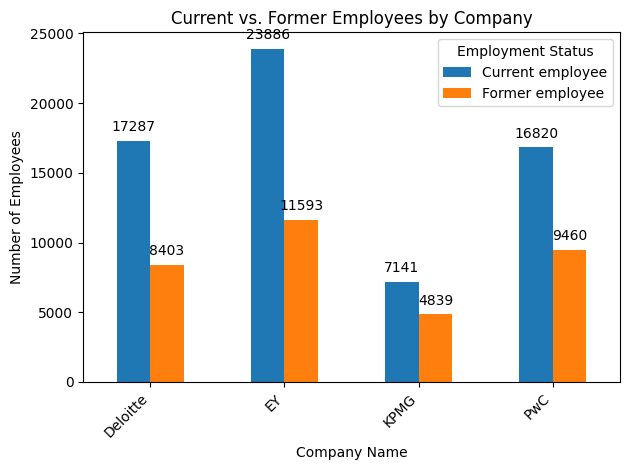

In [15]:
# prompt: create a bar chart for Current employee and Former employee by Company Name

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame as defined in the previous code

# Group data by company and employment status, then count occurrences
company_employee_counts = df.groupby(['Company Name', 'Employment Status']).size().unstack(fill_value=0)

# Create the bar plot using seaborn
plt.figure(figsize=(10, 6))
company_employee_counts.plot(kind='bar', stacked=False)  # Use stacked=False for non-stacked bars

plt.xlabel('Company Name')
plt.ylabel('Number of Employees')
plt.title('Current vs. Former Employees by Company')
plt.xticks(rotation=45, ha='right')

# Add counts on top of each bar
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')


plt.legend(title='Employment Status')
plt.tight_layout()
plt.show()

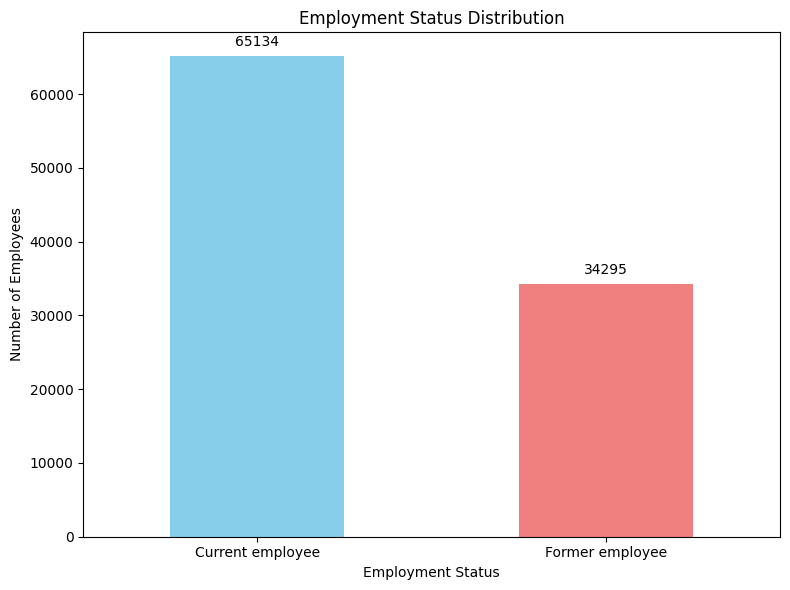

In [17]:
# prompt: create a bar chart of Employment Status count showing the count on the bar

import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame as defined in the previous code

# Group data by employment status and count occurrences
employment_status_counts = df['Employment Status'].value_counts()

# Create the bar plot
plt.figure(figsize=(8, 6))
employment_status_counts.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.xlabel('Employment Status')
plt.ylabel('Number of Employees')
plt.title('Employment Status Distribution')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal

# Add counts on top of each bar
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

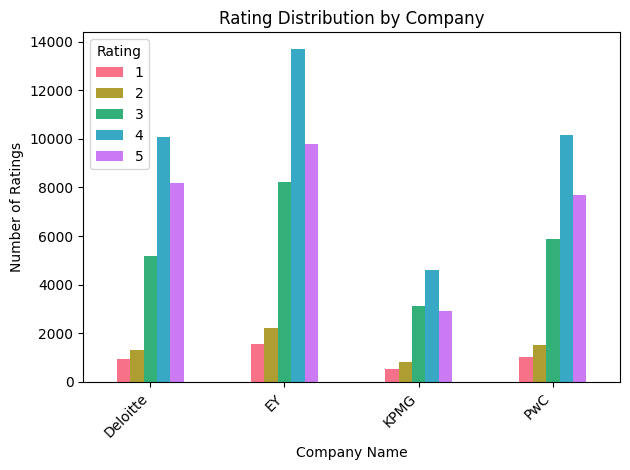

In [15]:
# prompt: create a bar chart for each rating count 1,2,3,4,5 across Company Name without showing the count in the chart with distinct colors

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame as defined in the previous code

# Group data by company and rating, then count occurrences
company_rating_counts = df.groupby(['Company Name', 'Overall Rating']).size().unstack(fill_value=0)

# Create a color palette with distinct colors for each rating
distinct_colors = sns.color_palette("husl", n_colors=5)  # 5 colors for ratings 1-5

# Create the bar plot using seaborn
plt.figure(figsize=(10, 6))
company_rating_counts.plot(kind='bar', color=distinct_colors)

plt.xlabel('Company Name')
plt.ylabel('Number of Ratings')
plt.title('Rating Distribution by Company')
plt.xticks(rotation=45, ha='right')

# Remove the count annotations
# (No annotations are added in this version of the code)

plt.legend(title='Rating')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

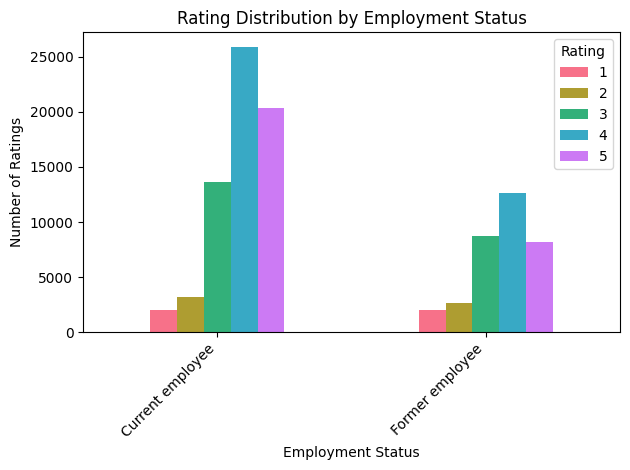

In [16]:
# prompt: create a bar chart for each rating count 1,2,3,4,5 across Employment Status without showing the count in the chart with distinct colors

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame as defined in the previous code

# Group data by employment status and rating, then count occurrences
employment_rating_counts = df.groupby(['Employment Status', 'Overall Rating']).size().unstack(fill_value=0)

# Create a color palette with distinct colors for each rating
distinct_colors = sns.color_palette("husl", n_colors=5)  # 5 colors for ratings 1-5

# Create the bar plot using seaborn
plt.figure(figsize=(10, 6))
employment_rating_counts.plot(kind='bar', color=distinct_colors)

plt.xlabel('Employment Status')
plt.ylabel('Number of Ratings')
plt.title('Rating Distribution by Employment Status')
plt.xticks(rotation=45, ha='right')

# Remove the count annotations (no annotations in this version)

plt.legend(title='Rating')
plt.tight_layout()
plt.show()

In [ ]:
"from sklearn.linear_model import LogisticRegression
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english', max_features=1000, max_df=0.95, min_df=0.05,ngram_range=(1, 2))),
    ('lda', LatentDirichletAllocation(n_components=2, random_state=42, learning_method='online',max_iter=10, learning_decay=0.7, n_jobs=-1)),
    ('classifier', LogisticRegression(random_state=42))
])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)
score = accuracy_score(y_test, y_pred)
print(f"LogisticRegression Accuracy: {score}")


LogisticRegression Accuracy: 0.6504073217338832


In [ ]:
!pip install scikit-learn
from sklearn.preprocessing import StandardScaler  # Import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# Sample data
texts = df['Review']
labels = df['employment status_encoded']

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    texts,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels  # Ensures class distribution is preserved
)

# Step 1: Vectorize text using TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000, max_df=0.95, min_df=0.05, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Step 2: Apply SMOTE to balance classes in the training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_vec, y_train)

# Step 3: Apply LDA
lda = LatentDirichletAllocation(
    n_components=2,
    random_state=42,
    learning_method='online',
    max_iter=10,
    learning_decay=0.7
)
X_train_lda = lda.fit_transform(X_train_res)
X_test_lda = lda.transform(X_test_vec)

# Step 4: Scale features
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_lda)
X_test_scaled = scaler.transform(X_test_lda)

# Step 5: Train SVM
classifier = SVC(kernel='rbf', random_state=42, probability=True)
classifier.fit(X_train_scaled, y_train_res)

# Predict and evaluate
y_pred = classifier.predict(X_test_scaled)
score = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {score}")
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.svm import SVC

pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english', max_features=1000, max_df=0.95, min_df=0.05,ngram_range=(1, 2))),
    ('lda', LatentDirichletAllocation(n_components=2, random_state=42, learning_method='online',max_iter=10, learning_decay=0.7, n_jobs=-1)),
    ('classifier', SVC(kernel='linear', random_state=42))
])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)
score = accuracy_score(y_test, y_pred)
print(f"SVC Accuracy: {score}")


SVC Accuracy: 0.6504073217338832


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english', max_features=1000, max_df=0.95, min_df=0.05,ngram_range=(1, 2))),
    ('lda', LatentDirichletAllocation(n_components=2, random_state=42, learning_method='online',max_iter=10, learning_decay=0.7, n_jobs=-1)),
    ('classifier', GradientBoostingClassifier(n_estimators=50, random_state=42))
])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)
score = accuracy_score(y_test, y_pred)
print(f"Accuracy: {score}")


Accuracy: 0.6505078950015086


In [ ]:
from sklearn.naive_bayes import MultinomialNB

pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english', max_features=1000, max_df=0.95, min_df=0.05,ngram_range=(1, 2))),
    ('lda', LatentDirichletAllocation(n_components=2, random_state=42, learning_method='online',max_iter=10, learning_decay=0.7, n_jobs=-1)),
    ('classifier', MultinomialNB())
])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)
score = accuracy_score(y_test, y_pred)
print(f"MultinomialNB Accuracy: {score}")


MultinomialNB Accuracy: 0.6504073217338832
